In [1]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import csv

#----------------------setting---------------------------#
ecg_filename = "time_ecg_rpeak_yeop_friend_sleep"
rr_filename = "rrinterval_yeop_friend_sleep_data"
#--------------------------------------------------------#

#ecg_ values
ecg_header = []
ecg_time = []
ecg_code = []
rpeak_time = []
rpeak_code = []
peak_index = []

#rr_values
rr_header = []
rr_index = []
rr_interval = []
hr_data = []

In [2]:
def read_ecg_from_csv(ecg_filename):
    filename = "data/"+ecg_filename+".csv"
    with open (filename,'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter = ',')
        ecg_header.append(reader.next())
        for row in reader:
            ecg_time.append(row[0])
            ecg_code.append(row[1])
            rpeak_time.append(row[2])
            rpeak_code.append(row[3])
            if row[3] != "0":
                peak_index.append(row)

In [3]:
def read_rr_from_csv(rr_filename):
    filename = "data/"+rr_filename+".csv"
    with open (filename,'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter = ',')
        rr_header.append(reader.next())
        for row in reader:
            rr_index.append(int(row[0]))
            rr_float = float(row[1])
            rr_interval.append(rr_float)
            hr_data.append((60*1000)/rr_float)

In [4]:
def get_hr_data(rr_interval) :
    for i in rr_interval:
        rr_interval[i] = int(rr_interval[i])
        hr_data.append = (60*1000)/rr_interval[i]

In [5]:
read_ecg_from_csv(ecg_filename)
read_rr_from_csv(rr_filename)

In [6]:
print("peak_point_number : " + str(len(peak_index))+
      "\necg_data_number : "+str(len(ecg_time))+
     "\nrr_index_number : "+str(len(rr_index))+
     "\necg_header : "+ str(ecg_header)+
     "\nrr_header : "+ str(rr_header))

peak_point_number : 5025
ecg_data_number : 1048575
rr_index_number : 16790
ecg_header : [['Time(H:M:S) - ECG', 'Code - ECG', 'Time(H:M:S) - R-Peak', 'Code - R-Peak']]
rr_header : [['History Index - RR', 'R-R Interval(ms) - RR']]


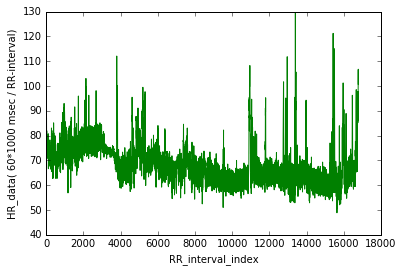

In [7]:
plt.plot(rr_index,hr_data,'g-')
plt.xlabel('RR_interval_index')
plt.ylabel('HR_data( 60*1000 msec / RR-interval)')
plt.ylim(40.0, 130.0)
plt.show()

In [8]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def to_ndarray(list):
    lgt = len(list)
    x = np.zeros((1,lgt),dtype ='float')
    for i in range(0,lgt):
        x[0,i]=list[i]
    return x

# for test, switch Code <-->Heading
rr_index = np.linspace(0.2, 0.8, 101)
hr_data = map(lambda x: 1/x, rr_index)
# copy & paste below data : x_test = np.linspace(0.2, 0.8, 10*len(rr_index))
# backup_code : x_test = np.linspace(0 ,len(rr_index),10*len(rr_index))

In [19]:
x_data = to_ndarray(rr_index)
y_data = to_ndarray(hr_data)

In [15]:
hiddenDim = 10

#linear Regression
W = weight_variable([hiddenDim,1])
b = bias_variable([hiddenDim,1])

W2 = weight_variable([1,hiddenDim])
b2 = bias_variable([1])

X = tf.placeholder("float",[1,None])

hidden = tf.nn.sigmoid(tf.matmul(W,X)+b)
regression = tf.matmul(W2,hidden) + b2

loss = tf.reduce_mean(tf.square( y_data - regression))

step = tf.Variable(0,trainable=False)
#rate = tf.train.exponential_decay(0.15, step,1, 0.9999)
rate = 0.01

optimizer = tf.train.AdamOptimizer(rate)
train = optimizer.minimize(loss, global_step = step)

In [16]:
init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

for step in xrange(2001):
    train.run({X: x_data},sess)
    if step % 100 == 0:
        print step, loss.eval({X: x_data},sess)

0 6.27872
100 0.888896
200 0.615912
300 0.32821
400 0.152624
500 0.0802549
600 0.0574373
700 0.0494924
800 0.0446386
900 0.0404279
1000 0.0364683
1100 0.0326803
1200 0.0290561
1300 0.0256158
1400 0.0223898
1500 0.0194102
1600 0.0167044
1700 0.0142919
1800 0.0121815
1900 0.01037
2000 0.00884384


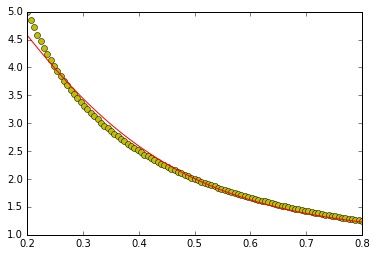

In [18]:
 x_test = np.linspace(0 ,len(rr_index),10*len(rr_index))
y_test = regression.eval({X:to_ndarray(x_test)},sess)

plt.plot(rr_index,hr_data,'yo')
plt.plot(x_test,y_test.transpose().tolist(),'r-')
plt.show()